<a href="https://colab.research.google.com/github/ghanbarifereshteh/singlecolorprj/blob/main/RNN2Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import TimeDistributed
from tensorflow.keras import datasets, layers, models
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,RNN
from keras.layers import Dropout,Attention
import IPython
import IPython.display
from math import floor

In [ ]:
import yfinance as yf
df_stock = yf.download('EURUSD=X','2003-12-01','2023-11-01')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#set hyper parameters.there is a sequence. the network sees the input days and predicts the other days. seq_len is the sum of inputs and offsets.
n_steps = 20
n_neurons = 200
n_layers = 2
learning_rate = 0.001
batch_size = 50
dropout_rate = 0.2
num_features = 6

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

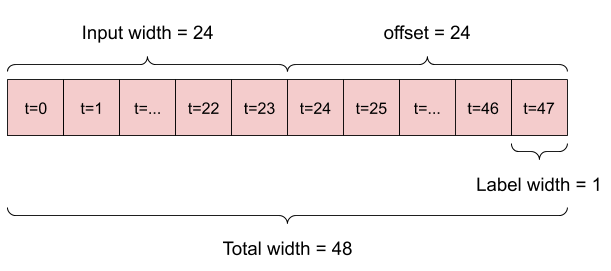

In [ ]:
#the data must be normalized so it becomes understandable for machine.
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

In [ ]:
#spilite data and and make three datasets for training and validation and test.
def spilitData(df_stock_norm):
  n = len(df_stock_norm)
  train_df = df_stock_norm[0:int(n*0.8)]
  val_df = df_stock_norm[int(n*0.8):int(n*0.9)]
  test_df = df_stock_norm[int(n*0.9):]

  num_features = df_stock_norm.shape[1]
  return train_df,val_df,test_df

In [ ]:
#because of normalization(between 0 and 1) some values become zero. in calculating the amount of profit, we may encounter divide by zero error. so zero values are deleted with this function.
def drop_zeros(df_stock):
  mask = (df_stock.drop(columns=['Volume']) == 0).any(axis=1)
  removed_rows = df_stock[mask]
  df_stock = df_stock[~mask]

  # Display the removed rows
  print("Removed Rows:")
  print(removed_rows)
  return df_stock

In [ ]:
class WindowGenerator():

  def __init__(self,df,input_width, label_width, shift,label_columns=None):
    # Work out the label column indices.
    self.column_indices ={name: i for i, name in enumerate(df.columns)}
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
#this function makes datasets like timeseries so they becomes suitable for a RNN network.
def make_dataset(self, data):

  data = np.array(data, dtype=np.float32)

  ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size= batch_size)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# the model consists of many RNN layers. each layer has many neurons. we increased the number of neurons and saw the accuracy improved.
# after RNN layers, there is a Dense layer that outputs six features.
# to avoid overfitting and also enhancing the model, we added a dropout.
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    layers = [tf.keras.layers.GRUCell(units=n_neurons, activation='tanh')
         for layer in range(n_layers)]

  # Create a multi-layer RNN cell
    self.lstm_cell = tf.keras.layers.StackedRNNCells(layers)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dense = tf.keras.layers.Dense(num_features,activation = 'relu')

In [ ]:
feedback_model = FeedBack(units=n_neurons, out_steps = n_steps)

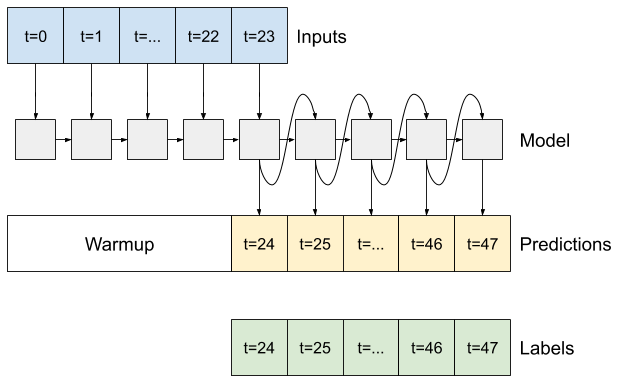

In [ ]:
#give the model time to warm up its internal state before making a single prediction
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)

  return prediction, state

FeedBack.warmup = warmup

In [ ]:
# this call function as you see in the image above, gets the predictions and gives them as input to the model again..
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                          training=training)
    if training:
      x = self.dropout(x)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
def stacked_RNN():
  layers = [tf.keras.layers.GRUCell(units=n_neurons, activation='elu')
         for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  # Define the RNN layer using the Sequential API
  model = tf.keras.Sequential([
      tf.keras.layers.RNN(multi_layer_cell, return_sequences=True),
      tf.keras.layers.Reshape(target_shape=(-1, n_neurons)),
      tf.keras.layers.Dense(num_features)
  ])
  return model

In [ ]:
def simple_RNN():

  # Define the RNN layer using the Sequential API
  model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(units=50, activation='tanh',return_sequences=True,dropout=0.2),
      tf.keras.layers.SimpleRNN(units=50, activation='tanh',return_sequences=True,dropout=0.2),
      tf.keras.layers.SimpleRNN(units=50, activation='tanh',return_sequences=True,dropout=0.2),
      tf.keras.layers.SimpleRNN(units=50, activation='tanh',dropout=0.2),
      tf.keras.layers.Dense(units=num_features)
  ])
  return model

In [ ]:
#MAX_EPOCHS = 150

def compile_and_fit(model, window,epoch, patience=10):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
   #                                                 patience=patience,
    #                                                mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=[tf.keras.losses.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epoch,
                      validation_data=window.val)
                     # callbacks=[early_stopping])
  return history

In [ ]:
 #for ploting and comparing target values and predictions, we need labels..
 #this function seperate inputs and labels from dataset.
 def get_input_Labels(ds):
  ds_inputs = []
  ds_labels = []
  for inputs, labels in ds:
      ds_inputs.append(inputs.numpy())
      ds_labels.append(labels.numpy())
  batch_input = []
  batch_labels = []
  for i in range(len(ds_labels)):
    for j in range(len(ds_labels[i])):
      batch_labels.append(ds_labels[i][j])
      batch_input.append(ds_inputs[i][j])
  return np.array(batch_input),np.array(batch_labels)

In [ ]:
def plot_target_predict(test_labels,predictions):
  # ploting the graph
  comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':predictions[:,-1,:][:,3]})
  plt.figure(figsize=(50,5))
  plt.plot(comp['Column1'], color='orange', label='Target')
  plt.plot(comp['Column2'], color='red', label='Prediction')
  plt.legend()
  plt.show()

In [ ]:
def plot(history):
  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
#it seems ploting is not enough for evaluating model. with this function the amount of profit will be obtained based on predictions.
def calculate_profit(predictions,test_inputs):
  amount_of_profit = 0
  for i in range(1,len(predictions)):
    if (test_inputs[i,-1,3] > test_inputs[i-1,-1,3]):
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if(predictions[i,-1,3] > test_inputs[i-1,-1,3]):
          amount_of_profit += ((min(predictions[i,-1,3],test_inputs[i,-1,3])-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]) *10000
        else:
          amount_of_profit += -((test_inputs[i,-1,3] - test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3] * 10000)
    else:
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if (predictions[i,-1,3] <test_inputs[i-1,-1,3] ):
          amount_of_profit += (test_inputs[i-1,-1,3] - max(predictions[i,-1,3],test_inputs[i,-1,3]))/test_inputs[i-1,-1,3] * 10000
        else:
          amount_of_profit += (test_inputs[i,-1,3]-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]*1000
  return amount_of_profit

In [ ]:
#in dynamic LSTM method, the actual value of the recently predicted
#date is added to the training dataset to rebuild the model to make predictions for data in
#the testing set
def dynamicLSTM(window,test_inputs,test_labels):
  val_inputs,val_labels = get_input_Labels(window.val)
  len_recent_data = 10
  i = 0
  new_predictions = np.empty(shape = (0,n_steps,num_features))
  print("len new pre..."+str(len(new_predictions)))
  iteration = floor(len(test_inputs)/len_recent_data)
  while i < iteration*len_recent_data :
      npredictions = feedback_model.predict(test_inputs[i:i+len_recent_data])
      new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
      combined_data = np.concatenate((val_inputs, test_inputs[i:i+len_recent_data]), axis=0)
      combined_data_labels = np.concatenate((val_labels, test_labels[i:i+len_recent_data]), axis=0)
      window.val = window.make_dataset(combined_data[:,-1,:],64)
      feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

      history = feedback_model.fit(combined_data,combined_data_labels, epochs=7,
                        validation_data=window.val)
      i += len_recent_data
      print("itrration....."+str(i))
  print("last i...."+str(i))
  npredictions = feedback_model.predict(test_inputs[i:])
  mse,mae = feedback_model.evaluate(test_inputs)
  new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
  plot_target_predict(test_labels,new_predictions)
  amount_of_profit = calculate_profit(new_predictions ,test_inputs)
  print("amount of profit....dynamic LSTM..."+str(amount_of_profit))

In [ ]:
def compile_model(model,epoch):
  history = compile_and_fit(model, multi_window,epoch)
  predictions = model.predict(multi_window.test)
  mse,mae = model.evaluate(multi_window.test)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  plot_target_predict(test_labels,predictions)
  profit = calculate_profit(predictions,test_inputs)
  print("profit...."+str(profit))
  print("mse,mae...."+str(mse)+", "+str(mae))
  return history,predictions

In [ ]:
  def run_stacked_RNN():
    model = stacked_RNN()
    return model

In [ ]:
def run_simple_RNN():
  model = simple_RNN()
  return model

In [ ]:
def get_input_CNN(df_stock):
  df_stock = normalize_data(df_stock)
  df_stock = drop_zeros(df_stock)
  train_df,val_df,test_df = spilitData(df_stock)
  multi_window = WindowGenerator(train_df,input_width=n_steps,
                                label_width=n_steps,
                                shift=1)
  multi_window.train = multi_window.make_dataset(train_df)
  multi_window.val = multi_window.make_dataset(val_df)
  multi_window.test = multi_window.make_dataset(test_df)
  train_inputs,train_labels = get_input_Labels(multi_window.train)
  val_inputs,val_labels = get_input_Labels(multi_window.val)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  subsequences = 4
  timesteps = train_inputs.shape[1]//subsequences

  X_train_series_sub = train_inputs.reshape((train_inputs.shape[0], subsequences, timesteps, num_features))
  X_valid_series_sub = val_inputs.reshape((val_inputs.shape[0], subsequences, timesteps, num_features))
  y_train_series_sub = train_inputs.reshape((train_labels.shape[0], subsequences, timesteps, num_features))
  y_valid_series_sub = val_inputs.reshape((val_labels.shape[0], subsequences, timesteps, num_features))
  X_test_series_sub = test_inputs.reshape((test_inputs.shape[0], subsequences, timesteps, num_features))
  return X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels


In [ ]:
def time_distributed_CNN_RNN(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
  conv1d_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))(input_layer)
  maxpooling_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2))(conv1d_layer)
  flatten_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(maxpooling_layer)
  lstm_layer = tf.keras.layers.LSTM(800,activation='relu')(flatten_layer)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(lstm_layer)
  final_layer = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  print("dense shape..."+str(final_layer .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(X_train_series_sub, train_labels, validation_data=(X_valid_series_sub, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(X_test_series_sub)
  mse, mae = model_cnn_lstm.evaluate(X_test_series_sub)
  plot_target_predict(test_labels,pred)
  profit = calculate_profit(pred,test_inputs)
  print("profit...."+str(profit))
  print("mse, mae...."+str(mse)+", "+str(mae))
  return cnn_history,pred

In [ ]:
def cocatenated_CNN_RNN(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))
  print("input layer..."+str(input_layer.shape))
  conv1d_layer = tf.keras.layers.Conv1D(128,4,strides=1, padding='same',activation='relu')(input_layer)
  print("conv1d_layer..."+str(conv1d_layer.shape))
  lstm_layer = tf.keras.layers.LSTM(128,activation='relu',return_sequences=True,dtype=tf.float32)(input_layer)
  print("lstm_layer..."+str(lstm_layer.shape))
  concat = tf.keras.layers.Concatenate(axis=-1)([conv1d_layer, lstm_layer])
  flatten_concat = tf.keras.layers.Flatten()(concat)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(flatten_concat)
  final_layer = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  print("dense shape..."+str(final_layer .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(test_inputs)
  mse, mae = model_cnn_lstm.evaluate(test_inputs)
  plot_target_predict(test_labels,pred)
  profit = calculate_profit(pred,test_inputs)
  print("profit...."+str(profit))
  print("mse, mae...."+str(mse)+", "+str(mae))
  return cnn_history,pred

**Results of Stacked RNN in different currency pairs:**

In [ ]:
df_stock = yf.download('EURUSD=X','2000-01-01','2023-10-14')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
  df_stock = normalize_data(df_stock)
  train_df,val_df,test_df = spilitData(df_stock)
  multi_window = WindowGenerator(train_df,input_width=n_steps,
                               label_width=1,
                               shift=1)
  multi_window.train = multi_window.make_dataset(train_df)
  multi_window.val = multi_window.make_dataset(val_df)
  multi_window.test = multi_window.make_dataset(test_df)

In [ ]:
model = run_simple_RNN()
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
train_inputs,train_labels = get_input_Labels(multi_window.train)
val_inputs,val_labels = get_input_Labels(multi_window.val)
train_labels = train_labels[:,-1,:]
val_labels = val_labels[:,-1,:]
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=100, verbose=2)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  pred = model.predict(test_inputs)
  mse, mae = model.evaluate(test_inputs)
  comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':pred[:,:][:,3]})
  plt.figure(figsize=(50,5))
  plt.plot(comp['Column1'], color='orange', label='Target')
  plt.plot(comp['Column2'], color='red', label='Prediction')
  plt.legend()
  plt.show()
  profit = calculate_profit(pred,test_inputs)
  print("profit...."+str(profit))
  print("mse, mae...."+str(mse)+", "+str(mae))
  return history,pred

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,100)

In [ ]:
history,predictions = compile_model(feedback_model,100)

In [ ]:
history,predictions = time_distributed_CNN_RNN(df_stock,500)

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0


dense shape...(None, 20, 6)
Epoch 1/500
129/129 - 13s - loss: 0.0322 - mean_absolute_error: 0.0865 - val_loss: 2.1460e-04 - val_mean_absolute_error: 0.0107 - 13s/epoch - 102ms/step
Epoch 2/500
129/129 - 2s - loss: 3.9194e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4812e-04 - val_mean_absolute_error: 0.0081 - 2s/epoch - 12ms/step
Epoch 3/500
129/129 - 2s - loss: 3.6015e-04 - mean_absolute_error: 0.0120 - val_loss: 1.2985e-04 - val_mean_absolute_error: 0.0076 - 2s/epoch - 16ms/step
Epoch 4/500


KeyboardInterrupt: ignored

In [ ]:
history,predictions = cocatenated_CNN_RNN(df_stock,300)

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0


input layer...(None, 20, 6)
conv1d_layer...(None, 20, 128)
lstm_layer...(None, 20, 128)
dense shape...(None, 20, 6)
Epoch 1/300
129/129 - 6s - loss: 0.0120 - mean_absolute_error: 0.0462 - val_loss: 1.2161e-04 - val_mean_absolute_error: 0.0076 - 6s/epoch - 48ms/step
Epoch 2/300
129/129 - 5s - loss: 2.8543e-04 - mean_absolute_error: 0.0108 - val_loss: 1.1506e-04 - val_mean_absolute_error: 0.0074 - 5s/epoch - 42ms/step
Epoch 3/300
129/129 - 4s - loss: 2.3481e-04 - mean_absolute_error: 0.0097 - val_loss: 8.2921e-05 - val_mean_absolute_error: 0.0062 - 4s/epoch - 30ms/step
Epoch 4/300


KeyboardInterrupt: ignored

In [ ]:
df_stock = yf.download('EURJPY=X','2000-01-01','2023-10-14')

In [ ]:
model = run_simple_RNN()
history,predictions = compile_model(model,100)

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,100)

In [ ]:
history,predictions = compile_model(feedback_model,100)

In [ ]:
history,predictions = time_distributed_CNN_RNN(df_stock,300)

In [ ]:
history,predictions = cocatenated_CNN_RNN(df_stock,200)

In [ ]:
df_stock = yf.download('EURGBP=X','2000-01-01','2023-10-14')

In [ ]:
model = run_simple_RNN()
history,predictions = compile_model(model,100)

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,100)

In [ ]:
history,predictions = compile_model(feedback_model,100)

In [ ]:
history,predictions = time_distributed_CNN_RNN(df_stock,300)

In [ ]:
history,predictions = cocatenated_CNN_RNN(df_stock,200)